# Rank authors
For any given article in the test dataset, compute the distance between the articles and authors in the train data set. For each article, rank the authors by distance. Expect the correct article authors to be at a shorter than average distance to the articles.



In [36]:
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
DATA_PATH = '../data'
MODELS_PATH = '../models'

## load the article metadata

In [38]:
def load_df(name):
    return pd.read_csv(
        os.path.join(DATA_PATH, name), 
        index_col=0, 
        converters={"authors_parsed": lambda x:[entry.replace("'", '').strip("[]") for entry in x.split("', '")]}
    )

validate9_df = load_df('validate_topics9.csv')
test9_df = load_df('test_topics9.csv')
train9_df = load_df('train_topics9.csv')

validate6_df = load_df('validate_topics6.csv')
test6_df = load_df('test_topics6.csv')
train6_df = load_df('train_topics6.csv')

validate12_df = load_df('validate_topics12.csv')
test12_df = load_df('test_topics12.csv')
train12_df = load_df('train_topics12.csv')

## Rank authors by distance to a given article

In [39]:
# load the topics by author
authors9_validate_df = pd.read_csv(os.path.join(DATA_PATH, 'validate_topics9_authors.csv'), index_col=0)
authors9_test_df = pd.read_csv(os.path.join(DATA_PATH, 'test_topics9_authors.csv'), index_col=0)
authors9_train_df = pd.read_csv(os.path.join(DATA_PATH, 'train_topics9_authors.csv'), index_col=0)

authors6_validate_df = pd.read_csv(os.path.join(DATA_PATH, 'validate_topics6_authors.csv'), index_col=0)
authors6_test_df = pd.read_csv(os.path.join(DATA_PATH, 'test_topics6_authors.csv'), index_col=0)
authors6_train_df = pd.read_csv(os.path.join(DATA_PATH, 'train_topics6_authors.csv'), index_col=0)

authors12_validate_df = pd.read_csv(os.path.join(DATA_PATH, 'validate_topics12_authors.csv'), index_col=0)
authors12_test_df = pd.read_csv(os.path.join(DATA_PATH, 'test_topics12_authors.csv'), index_col=0)
authors12_train_df = pd.read_csv(os.path.join(DATA_PATH, 'train_topics12_authors.csv'), index_col=0)

In [40]:
import numpy as np

def topic_distance(topics1, topics2):
    """
    topic1, topic2: numpy.ndarray, representing the probability that an article is about a topic. An article can have multiple topics.
    Example:
        0    0.000000
        1    0.000000
        2    0.000000
        3    0.000000
        4    0.000000
        5    0.992668
    topic1 and topic2 must be the same length.
    Topics were assigned to articles in 03_assign_topics
    """
    dist = np.linalg.norm(topics1 - topics2)  # euclidean distance, L2 norm is default
    return dist

In [44]:
mask9 = validate9_df.columns.str.contains("topic9_.")
mask6 = validate6_df.columns.str.contains("topic6_.")
mask12 = validate12_df.columns.str.contains("topic12_.")

In [47]:
def distances(article, authors_df, mask):
    """
    Get the distance between article and all authors, in the topic space 
    
    article: pandas.DataFrame data for a single article
    authors_df: pandas.DataFrame data for all authors
    mask: numpy.array of boolean: which columns to use (e.g. topic9_01, ...)
    return: pandas.DataFrame in the form distance, author
    """
    # numpy array with topics probabilities for the article
    topics1 = np.array(article.loc[:, mask])
    # compute distances between article topics and topics of all authors
    topics_authors_np = authors_df[authors_df.columns.drop('author')].to_numpy() 
    distances = [topic_distance(topics1, topics2) for topics2 in topics_authors_np]
    distances_df = pd.DataFrame({'author': authors_df['author'], 'distance': distances})
    distances_df.sort_values(by='distance', ascending=True, inplace=True)
    return distances_df


def rank_author(article, authors_df, mask):
    """
    Get the lowest rank of any of the authors of article within authors_df.
    
    article: pandas.DataFrame data for a single article
    authors_df: pandas.DataFrame data for all authors
    return: int rank of closest author
    """
    rank = 0
    found = False
    distances_df = distances(article, authors_df, mask)
    for dataset_author in distances_df.author:
        for article_author in rnd_article.authors_parsed.iloc[0]:
            if article_author == dataset_author:
                found = True
                break
        if found: break
        rank += 1
    # check of found
    if not found:
        return None, None
    else:
        return article_author, rank

### Example 1
Pick a random article from the validate data set, find the rank of the nearest author in validate dataset.
Expect the rank to be low in the majority of cases. 

In [48]:
# pick a random paper
rnd_article = validate9_df.sample()
closest_author, rank = rank_author(rnd_article, authors9_validate_df, mask9)

# check
print(f"The original article \"{rnd_article.title.iloc[0]}\" authors are: {rnd_article.authors_parsed.iloc[0]}")
print(f"The closest author is: '{closest_author}', with distance rank {rank}.")

The original article "RXJ0437+00: Constraining Dark Matter with Exotic Gravitational Lenses" authors are: ['Lagattuta, David J., ', 'Richard, Johan, ', 'Ebeling, Harald, ', 'Basto, Quentin, ', 'Cerny, Catherine, ', 'Edge, Alastair, ', 'Jauzac, Mathilde, ', 'Mahler, Guillaume, ', 'Massey, Richard, ']
The closest author is: 'Ebeling, Harald, ', with distance rank 0.


### Example 2
Pick a random article from the validate data set, by an author who is also in the train dataset. Find the nearest author in train dataset.

In [53]:
# Percentage of authors in validate dataset, that are also present in train dataset
authors_validate_set = set(authors9_validate_df.author)
authors_train_set = set(authors9_train_df.author)
authors_intersection = authors_validate_set.intersection(authors_train_set)
print(f"The validate dataset has {len(authors_validate_set)} authors, the train dataset has {len(authors_train_set)}, and {len(authors_intersection)} authors are in both datasets.")

The validate dataset has 101576 authors, the train dataset has 157213, and 50935 authors are in both datasets.


In [55]:
# get articles in validate dataset, written by authors who are in both datasets
intersection_ids = []
for i, row in validate_df.iterrows():
    for author in row.authors_parsed:
        # if at least one author is in both datasets, keep the article id
        if author in authors_intersection:
            intersection_ids.append(row.id)
            break

idx = [article_id in intersection_ids for article_id in validate_df.id]
intersection9_articles_df = validate9_df[idx]

print(f"{intersection_articles_df.shape[0]} out of {validate_df.shape[0]} articles in the validate dataset were written by authors present in the validate and the train datasets")
print(f"i.e. {intersection_articles_df.shape[0]/validate_df.shape[0]*100:.2f} %")

19005 out of 22632 articles in the validate dataset were written by authors present in the validate and the train datasets
i.e. 83.97 %


In [56]:
# pick a random paper
rnd_article = intersection_articles_df.sample()
closest_author, rank = rank_author(rnd_article, authors9_train_df, mask9)

# check
print(f"The original article \"{rnd_article.title.iloc[0]}\" authors are: {rnd_article.authors_parsed.iloc[0]}")
print(f"The closest author is: '{closest_author}', with distance rank {rank}.")

The original article "Aspects of Categorical Symmetries from Branes: SymTFTs and Generalized
  Charges" authors are: ['Apruzzi, Fabio, ', 'Bonetti, Federico, ', 'Gould, Dewi S. W., ', 'Schafer-Nameki, Sakura, ']
The closest author is: 'Apruzzi, Fabio, ', with distance rank 340.


### Test
Pick 10000 random articles in the test dataset. Find the rank of the closest author for each article. Check that they are closer than a random author.

In [67]:
%%time

MAX_ARTICLES = 1000
ranks9 = []
ranks6 = []
ranks12 = []
for _ in range(MAX_ARTICLES):
    # pick a random paper in the test dataset, get the rank of the closest author in the train dataset
    rnd_article = test9_df.sample()
    _, rank = rank_author(rnd_article, authors9_train_df, mask9)
    ranks9.append(rank)

    # pick a random paper in the test dataset, get the rank of the closest author in the train dataset
    rnd_article = test6_df.sample()
    _, rank = rank_author(rnd_article, authors6_train_df, mask6)
    ranks6.append(rank)

    # pick a random paper in the test dataset, get the rank of the closest author in the train dataset
    rnd_article = test12_df.sample()
    _, rank = rank_author(rnd_article, authors12_train_df, mask12)
    ranks12.append(rank)

CPU times: user 33min 13s, sys: 2.63 s, total: 33min 15s
Wall time: 33min 16s


In [68]:
print(f"Found {len([x for x in ranks9 if x is not None])} authors out of {MAX_ARTICLES}")
ranks9 = [x for x in ranks9 if x is not None]

print(f"Found {len([x for x in ranks6 if x is not None])} authors out of {MAX_ARTICLES}")
ranks6 = [x for x in ranks6 if x is not None]

print(f"Found {len([x for x in ranks12 if x is not None])} authors out of {MAX_ARTICLES}")
ranks12 = [x for x in ranks12 if x is not None]

Found 839 authors out of 1000
Found 829 authors out of 1000
Found 854 authors out of 1000


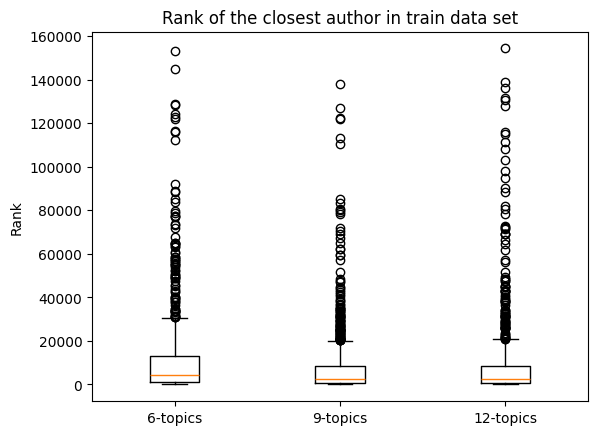

In [69]:
data = [ranks6, ranks9, ranks12]
fig, ax = plt.subplots()
ax.boxplot(data, tick_labels=['6-topics', '9-topics', '12-topics'])
ax.set_ylabel("Rank")
plt.title(f"Rank of the closest author in train data set")
plt.show()

In [70]:
pd.Series(ranks6).describe()

count       829.000000
mean      11673.173703
std       20128.458373
min           0.000000
25%        1024.000000
50%        4180.000000
75%       12877.000000
max      153054.000000
dtype: float64

In [71]:
pd.Series(ranks9).describe()

count       839.000000
mean       8423.169249
std       15927.156088
min           1.000000
25%         766.500000
50%        2702.000000
75%        8544.500000
max      138220.000000
dtype: float64

In [72]:
pd.Series(ranks12).describe()

count       854.00000
mean       9298.41452
std       19172.29195
min           0.00000
25%         543.25000
50%        2708.00000
75%        8678.25000
max      154353.00000
dtype: float64